In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fast_ai_exp/'

In [0]:
from fastai.text import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', -1)


In [40]:
text_content = base_dir + 'title_StackOverflow.txt'
label_content = base_dir + 'label_StackOverflow.txt'

df_text_data = pd.read_csv(text_content, sep='\t', names=['text'], header=None)
df_label_data = pd.read_csv(label_content, sep='\t', names=['labels'], header=None)

df = pd.concat([df_label_data, df_text_data], axis=1, sort=False)
df.head()

,labels,text
0,18,How do I fill a DataSet or a DataTable from a LINQ query resultset ?
1,18,How do you page a collection with LINQ?
2,3,Best Subversion clients for Windows Vista (64bit)
3,3,"Best Practice: Collaborative Environment, Bin Directory, SVN"
4,7,Visual Studio Setup Project - Per User Registry Settings


In [41]:
len(df)

20000

In [0]:
label_switch = {
  1: 'wordpress',
  2: 'oracle',
  3: 'svn',
  4: 'apache',
  5: 'excel',
  6: 'matlab',
  7: 'visual-studio',
  8: 'cocoa',
  9: 'osx',
  10: 'bash',
  11: 'spring',
  12: 'hibernate',
  13: 'scala',
  14: 'sharepoint',
  15: 'ajax',
  16: 'qt',
  17: 'drupal',
  18: 'linq',
  19: 'haskell',
  20: 'magento'
}

df.labels = df.labels.map(label_switch)

In [43]:
df.head()

,labels,text
0,linq,How do I fill a DataSet or a DataTable from a LINQ query resultset ?
1,linq,How do you page a collection with LINQ?
2,svn,Best Subversion clients for Windows Vista (64bit)
3,svn,"Best Practice: Collaborative Environment, Bin Directory, SVN"
4,visual-studio,Visual Studio Setup Project - Per User Registry Settings


In [44]:
df_train, df_validate = train_test_split(df, stratify=df['labels'], test_size=0.2)
df_train.shape, df_validate.shape

((16000, 2), (4000, 2))

In [45]:
language_model = TextLMDataBunch.from_df(train_df=df_train, valid_df=df_validate, path='')
classification_model = TextClasDataBunch.from_df(train_df=df_train, valid_df=df_validate, path='', vocab=language_model.train_ds.vocab, bs=32)

In [46]:
classification_model.show_batch()

text,target
"xxbos xxmaj in apache , if i go to https : / / xxunk , the page itself is over https , but all images / links are http : / / . xxmaj is there way to auto rewrite the html so its all https : / / ?",apache
xxbos how to select k no . of nodes with probability xxunk xxunk ) out of xxunk xxunk ) randomly generated nodes and those k nodes shown as red colored in whole figure ?,matlab
xxbos c : \ xxmaj documents and xxmaj settings \ user \ xxmaj my xxmaj documents \ xxunk \ xxunk xxunk xxunk \ xxunk : xxmaj the module has not been deployed .,ajax
"xxbos xxmaj when using xxunk , is there a way to customize the xxunk dialog that gets displayed ? ( xxmaj or show a different xxmaj cocoa dialog ? )",osx
"xxbos xxmaj how do i reference to another ( open or closed ) workbook , and pull values back , in xxup vba ? - xxmaj excel 2007",excel


In [0]:
language_model.save(base_dir + 'stack_language_model.pkl')
classification_model.save(base_dir + 'stack_classification_model.pkl')

language_model = load_data('./', base_dir + 'stack_language_model.pkl')
classification_model = load_data('./', base_dir + 'stack_classification_model.pkl', bs=64)

In [0]:
learn = language_model_learner(language_model, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 7.59E-02


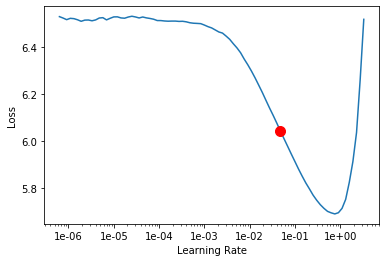

In [49]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_gradient_lrn_rate = learn.recorder.min_grad_lr

In [50]:
learn.fit_one_cycle(2, min_gradient_lrn_rate)

epoch,train_loss,valid_loss,accuracy,time
0,4.751244,4.039591,0.315048,00:08
1,4.090837,3.923200,0.327158,00:08


In [51]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.497683,3.812612,0.337612,00:11
1,3.318425,3.814965,0.340476,00:11


In [52]:
learn.predict('How can ', n_words=13)

'How can  i you read a source from my persistent through the dependency injection send'

In [0]:
learn.save_encoder(base_dir + 'stcks_oflow_encoder')

In [54]:
learn = text_classifier_learner(classification_model, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(base_dir + 'stcks_oflow_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (16000 items)
x: TextList
xxbos xxmaj excel xxmaj pivot table range reference,xxbos xxmaj advanced directory switching in bash,xxbos xxunk without an xxunk ( ) ?,xxbos xxmaj can i use xxmaj magento without the sales features ? xxmaj or am i better off with a scratch build ?,xxbos xxmaj maximum expression string length in regexp ( xxup matlab )
y: CategoryList
excel,bash,visual-studio,magento,matlab
Path: .;

Valid: LabelList (4000 items)
x: TextList
xxbos xxmaj obtaining an object state,xxbos xxmaj one xxmaj sharepoint xxmaj feature or many xxunk xxunk ones,xxbos xxmaj hibernate entity with user defined attributes,xxbos jdbctemplate hangs on long update,xxbos xxmaj apache configuration help -- xxmaj why are different processes " in " different time zones ?
y: CategoryList
hibernate,sharepoint,hibernate,spring,apache
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 4.37E-02


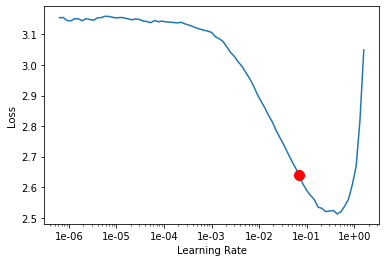

In [55]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_gradient_learn_rate = learn.recorder.min_grad_lr

In [56]:
learn.fit_one_cycle(2, min_gradient_learn_rate)

epoch,train_loss,valid_loss,accuracy,time
0,1.624229,1.158903,0.669750,00:06
1,1.361690,0.965725,0.737250,00:06


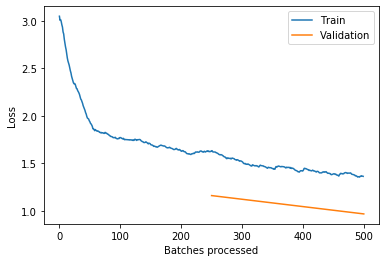

In [57]:
learn.recorder.plot_losses()

In [58]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.079213,0.721366,0.801250,00:07
1,0.832256,0.588731,0.832500,00:07
2,0.664221,0.548725,0.844000,00:07
3,0.609233,0.540476,0.846000,00:07


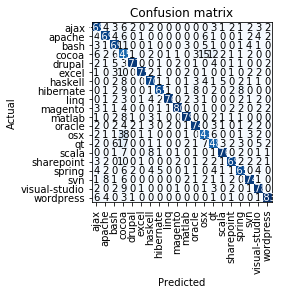

In [59]:
predictions, y, losses = learn.get_preds(with_loss=True)
interpret = ClassificationInterpretation(learn, predictions, y, losses)
interpret.plot_confusion_matrix()

In [60]:
interpret.most_confused()

[('osx', 'cocoa', 38),
 ('qt', 'cocoa', 17),
 ('cocoa', 'osx', 15),
 ('cocoa', 'qt', 12),
 ('bash', 'cocoa', 11),
 ('excel', 'cocoa', 10),
 ('sharepoint', 'cocoa', 10),
 ('hibernate', 'cocoa', 9),
 ('visual-studio', 'cocoa', 9),
 ('haskell', 'cocoa', 8),
 ('hibernate', 'oracle', 8),
 ('hibernate', 'spring', 8),
 ('matlab', 'cocoa', 8),
 ('scala', 'haskell', 8),
 ('svn', 'apache', 8),
 ('qt', 'osx', 7),
 ('scala', 'cocoa', 7),
 ('ajax', 'cocoa', 6),
 ('apache', 'cocoa', 6),
 ('apache', 'osx', 6),
 ('cocoa', 'ajax', 6),
 ('cocoa', 'bash', 6),
 ('osx', 'qt', 6),
 ('qt', 'bash', 6),
 ('spring', 'cocoa', 6),
 ('svn', 'cocoa', 6),
 ('wordpress', 'ajax', 6),
 ('bash', 'osx', 5),
 ('drupal', 'bash', 5),
 ('haskell', 'scala', 5),
 ('qt', 'visual-studio', 5),
 ('spring', 'hibernate', 5),
 ('ajax', 'apache', 4),
 ('apache', 'ajax', 4),
 ('apache', 'bash', 4),
 ('apache', 'visual-studio', 4),
 ('bash', 'svn', 4),
 ('drupal', 'qt', 4),
 ('haskell', 'osx', 4),
 ('linq', 'haskell', 4),
 ('magento', '

In [61]:
learn.predict('http not working')

(Category apache,
 tensor(1),
 tensor([3.4268e-03, 9.9205e-01, 1.4725e-04, 3.5532e-05, 7.7591e-04, 7.7226e-05,
         3.8558e-05, 1.1885e-04, 1.8469e-05, 1.5338e-04, 4.5875e-06, 7.3740e-04,
         5.1587e-04, 9.0395e-05, 1.2800e-05, 2.7788e-04, 3.6878e-04, 4.8667e-04,
         2.2779e-04, 4.3661e-04]))

In [0]:
learn.export(base_dir + 'stack_oflow_model')